# imports

In [1]:
import pandas as pd
import numpy as np
import string
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from datetime import datetime

# use progress_apply to show progress of long processing
from tqdm.notebook import tqdm
tqdm.pandas()  # enable progress_apply

# clean data

In [2]:
# # test with subset
# df = pd.read_csv("../data/csv/twitter/twitter_scraped_df.csv", nrows=100)

In [3]:
df = pd.read_csv("../data/csv/twitter/twitter_scraped_df.csv")
# df = pd.read_csv("../data/csv/twitter/twitter_scraped_df.csv")
print(df.shape)
df.head(2)

(105871, 31)


,createdAt,id,url,text,source,date,time of day,location,retweetCount,replyCount,...,user_mentions_indices_0,user_mentions_indices_1,user_mentions_name,user_mentions_screen_name,reply_to_user_results,quoted_tweet_results,quoted_tweet,retweeted_tweet,isConversationControlled,searchTermIndex
0,2022-01-02 00:00:46+00:00,1477429624208564226,https://x.com/KlausRieneck/status/147742962420...,The decision to phase out nuclear power and sh...,NaN,2022-01-02,0,NaN,0.0,0.0,...,NaN,NaN,NaN,NaN,"{'rest_id': '891466309619380224', 'result': {'...",NaN,NaN,NaN,False,0.0
1,2022-01-02 00:00:50+00:00,1477429640675446785,https://x.com/EINRenewables/status/14774296406...,"EU Moves to Label Nuclear, Natural Gas Energy ...",NaN,2022-01-02,0,NaN,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,0.0


## ensure **createdAt** in **dtype** format

In [4]:
df['createdAt'] = pd.to_datetime(df['createdAt'])
print(df['createdAt'].dtype)
print(df['createdAt'][0:2])

datetime64[ns, UTC]
0   2022-01-02 00:00:46+00:00
1   2022-01-02 00:00:50+00:00
Name: createdAt, dtype: datetime64[ns, UTC]


## extract author from url and insert as new column after 'id'

In [5]:
'''
# extract author from url using regex
https://x.com/EINRenewables/status/14774296406
https://x.com/KlausRieneck/status/147742962420
'''

df['author'] = df['url'].str.extract(r'x\.com/([^/]+)/status')
print(df['author'])

df = df.dropna(subset=['author'])
# print(df['author'])

0            KlausRieneck
1           EINRenewables
2         stanleychen0402
3         RenewableSearch
4                  klbout
               ...       
105866       FanofMerkley
105867       KrankstarNFT
105868      udkbk84386636
105869       truth_zeeker
105870         Jamesdanab
Name: author, Length: 105871, dtype: object


In [6]:
# move 'author' column after 'id'
cols = list(df.columns)
if 'author' in cols:
    author_idx = cols.index('id') + 1
    cols.insert(author_idx, cols.pop(cols.index('author')))
    df = df[cols]

df.head(2)

,createdAt,id,author,url,text,source,date,time of day,location,retweetCount,...,user_mentions_indices_0,user_mentions_indices_1,user_mentions_name,user_mentions_screen_name,reply_to_user_results,quoted_tweet_results,quoted_tweet,retweeted_tweet,isConversationControlled,searchTermIndex
0,2022-01-02 00:00:46+00:00,1477429624208564226,KlausRieneck,https://x.com/KlausRieneck/status/147742962420...,The decision to phase out nuclear power and sh...,NaN,2022-01-02,0,NaN,0.0,...,NaN,NaN,NaN,NaN,"{'rest_id': '891466309619380224', 'result': {'...",NaN,NaN,NaN,False,0.0
1,2022-01-02 00:00:50+00:00,1477429640675446785,EINRenewables,https://x.com/EINRenewables/status/14774296406...,"EU Moves to Label Nuclear, Natural Gas Energy ...",NaN,2022-01-02,0,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,0.0


## drop columns if only contain 1 unique value or if all values are NaN

In [7]:
columns = df.columns
for col in columns:
    if df[col].nunique(dropna=False) == 1 or df[col].isna().all():
        df = df.drop(columns=[col])
df.head(2)

,createdAt,id,author,url,text,date,retweetCount,replyCount,likeCount,quoteCount,...,inReplyToUserId,inReplyToUsername,user_mentions_id_str,user_mentions_indices_0,user_mentions_indices_1,user_mentions_name,user_mentions_screen_name,reply_to_user_results,quoted_tweet_results,quoted_tweet
0,2022-01-02 00:00:46+00:00,1477429624208564226,KlausRieneck,https://x.com/KlausRieneck/status/147742962420...,The decision to phase out nuclear power and sh...,2022-01-02,0.0,0.0,0.0,0.0,...,8.914663e+17,KlausRieneck,NaN,NaN,NaN,NaN,NaN,"{'rest_id': '891466309619380224', 'result': {'...",NaN,NaN
1,2022-01-02 00:00:50+00:00,1477429640675446785,EINRenewables,https://x.com/EINRenewables/status/14774296406...,"EU Moves to Label Nuclear, Natural Gas Energy ...",2022-01-02,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## get unique tweet authors

In [8]:
unique_authors = df['author'].unique()
print(unique_authors[0:5])
print(len(unique_authors))
print(len(df))

['KlausRieneck' 'EINRenewables' 'stanleychen0402' 'RenewableSearch'
 'klbout']
59747
105867


# preprocess

## focus on tweet content, ignore twitter metrics columns for now

In [9]:
df = df[['createdAt', 'id', 'author', 'url', 'text']]
df.head(2)

,createdAt,id,author,url,text
0,2022-01-02 00:00:46+00:00,1477429624208564226,KlausRieneck,https://x.com/KlausRieneck/status/147742962420...,The decision to phase out nuclear power and sh...
1,2022-01-02 00:00:50+00:00,1477429640675446785,EINRenewables,https://x.com/EINRenewables/status/14774296406...,"EU Moves to Label Nuclear, Natural Gas Energy ..."


## check for missing values, do we need to delete or impute?

In [10]:
print(df.isnull().sum())
df.shape

createdAt    0
id           0
author       0
url          0
text         0
dtype: int64


(105867, 5)

## clean text

In [11]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # remove whitespace
    text = text.strip(' ')

    # lowercase
    text = text.lower()

    # use regex to remove hyperlinks starting with http
    text = re.sub(r'http\S+', '', text)

    # remove punctuation and symbols like #"*!&%
    text = text.translate(str.maketrans('', '', string.punctuation))

    # tokenize
    tokens = word_tokenize(text)

    # sentiment analysis --> keep stopwords
    # to identify difference between 'not happy' and the separate words 'not', 'happy'

    # lemmatize to group words by their meaning instead of their exact form
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in tokens]
    lemmatized_string = ' '.join(lemmatized_words)  # join back to string

    return lemmatized_string

In [12]:
df['text_clean'] = df['text'].apply(preprocess_text)

pd.set_option('display.max_colwidth', None)
print(df['text'][0:2])
print(df['text_clean'][0:2])

0    The decision to phase out nuclear power and shift from fossil fuels to renewable energy was first taken by the centre-left government of former Chancellor Gerhard Schroeder in 2002 who nows has a prominent position in Russian Gazprom company.
1                                                                                                                                                                      EU Moves to Label Nuclear, Natural Gas Energy as 'Green' https://t.co/hPR2zCdZFU
Name: text, dtype: object
0    the decision to phase out nuclear power and shift from fossil fuel to renewable energy wa first taken by the centreleft government of former chancellor gerhard schroeder in 2002 who now ha a prominent position in russian gazprom company
1                                                                                                                                                                                             eu move to label nuclear natural gas energy a 

# sentiment analysis

## model "twitter-roberta-base-sentiment-latest"

In [13]:
%%capture
%pip install transformers torch;
%pip install datasets;
%pip install torch;
%pip install tqdm;
# use %%capture to suppress cell output

In [14]:
import transformers
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize
from collections import Counter
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from datasets import Dataset, ClassLabel
from transformers import TrainingArguments
from transformers import Trainer


[nltk_data] Error loading punkt: <urlopen error TLS/SSL connection has
[nltk_data]     been closed (EOF) (_ssl.c:997)>


## Setting up the model

In [15]:
from transformers import pipeline
sentiment_pipeline = pipeline("sentiment-analysis", model="cardiffnlp/twitter-roberta-base-sentiment-latest")
sentiment_pipeline

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


## divide text into chunks of N sentences each

In [16]:
def split_into_chunks(text, max_sentences=5):
    sentences = sent_tokenize(text)
    return [' '.join(sentences[i:i+max_sentences]) for i in range(0, len(sentences), max_sentences)]


In [17]:
def analyze_sentiment_chunked(text):
    "Analyse sentiment of chunks and labels 'mixed' if there is a meaningful draw"
    try:
        # max chars per chunk
        chunks = split_into_chunks(text[:400])

        # Process each chunk with explicit max_length
        results = []
        for chunk in chunks:
            try:
                result = sentiment_pipeline(chunk, truncation=True, max_length=512)[0]
                results.append(result)
            except Exception as chunk_e:
                print(f"Error processing chunk: {chunk_e}")
                continue

        # Handle case with no valid results
        if not results:
            return pd.Series(['NEUTRAL', 0.0])

        labels = [r['label'] for r in results]
        scores = [r['score'] for r in results]

        counter = Counter(labels)
        majority_label, count = counter.most_common(1)[0]
        avg_score = sum([s for l, s in zip(labels, scores) if l == majority_label]) / count

        if avg_score < 0.4:
            majority_label = 'NEUTRAL'

        return pd.Series([majority_label, avg_score])
    except Exception as e:
        print(f"Error in analyze_sentiment_chunked: {e}")
        return pd.Series(['NEUTRAL', 0.0])  # Return default values instead of None

## sentiment output and confidence score

### sample data-subset

In [18]:
# df_sample = df[['text', 'text_clean']].sample(n=100, random_state=42).copy()
# df_sample[['sentiment', 'confidence score']] = df_sample['text_clean'].progress_apply(analyze_sentiment_chunked)
# df_sample.head(3)

#### save to .csv file

In [19]:
# df_sample.to_csv('../data/csv/twitter/twitter_sentiment_analysis_sample.csv', index=False, encoding='utf-8')

### entire dataset

In [20]:
df[['sentiment', 'confidence score']] = df['text_clean'].progress_apply(analyze_sentiment_chunked)
print(df[['sentiment', 'confidence score']].head(3))

  0%|          | 0/105867 [00:00<?, ?it/s]

  sentiment  confidence score
0   neutral          0.902089
1   neutral          0.876217
2   neutral          0.816128


### drop rows with sentiment confidence score below threshold

In [21]:
confidence_threshold = 0.3

low_confidence_ids = df.loc[df['confidence score'] < confidence_threshold, 'id'].tolist()

print(f"dropping {len(low_confidence_ids)} rows (={len(low_confidence_ids) / len(df) * 100:.2f}% of entire dataset) with confidence score < threshold of {confidence_threshold}")

# drop rows with low confidence scores
df = df[df['confidence score'] >= confidence_threshold]

dropping 170 rows (=0.16% of entire dataset) with confidence score < threshold of 0.3


#### save to .csv file

In [22]:
df.to_csv('../data/csv/twitter/twitter_sentiment_analysis.csv', index=False, encoding='utf-8')

# data analysis

## histogram confidence and color by sentiment

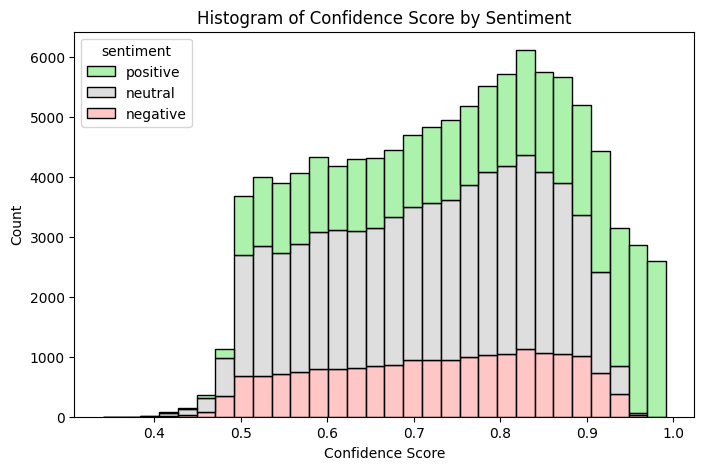

In [23]:
# histogram confidence and color by sentiment
import seaborn as sns
import matplotlib.pyplot as plt

sentiment_colors = {'negative': '#ffb3b3', 'neutral': '#d3d3d3', 'positive': '#90ee90'}

plt.figure(figsize=(8, 5))
sns.histplot(
    data=df,
    x='confidence score',
    hue='sentiment',
    multiple='stack',
    palette=sentiment_colors,
    bins=30,
    hue_order=['positive', 'neutral', 'negative']
)
plt.title('Histogram of Confidence Score by Sentiment')
plt.xlabel('Confidence Score')
plt.ylabel('Count')
plt.show()


## sentiment development over time (shares)

/tmp/ipykernel_11150/2835348701.py:10: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['quarter'] = df['createdAt'].dt.to_period('Q')


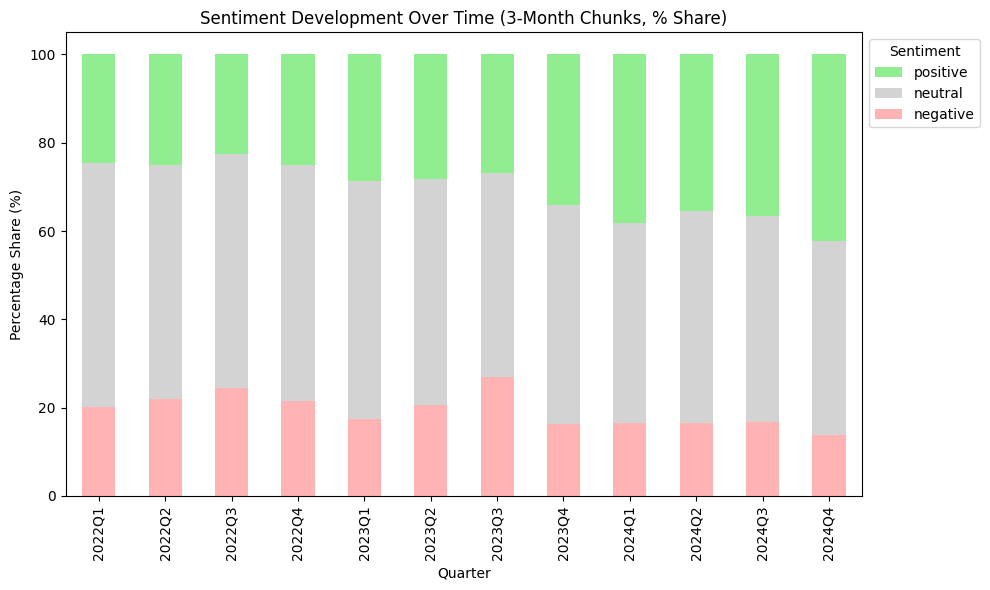

In [24]:
# plot sentiment development over time, group into 3-month chunks, show shares of 100%

# Combine 'NEUTRAL' and 'neutral' into a single 'neutral' label
df['sentiment'] = df['sentiment'].replace({'NEUTRAL': 'neutral'})

# Define custom colors for each sentiment
sentiment_colors = {'positive': '#90ee90', 'neutral': '#d3d3d3', 'negative': '#ffb3b3'}

# Group by 3-month periods and plot sentiment shares (percentages) over time
df['quarter'] = df['createdAt'].dt.to_period('Q')
sentiment_counts = df.groupby(['quarter', 'sentiment']).size().unstack(fill_value=0)

# Calculate shares (percentages) for each sentiment per quarter
sentiment_shares = sentiment_counts.div(sentiment_counts.sum(axis=1), axis=0) * 100

# Ensure columns are in the desired order: positive, neutral, negative
sentiment_order = ['negative', 'neutral', 'positive']  # positive on top
sentiment_shares_plot = sentiment_shares[sentiment_order]

plt.figure(figsize=(10, 6))
sentiment_shares_plot.plot(
    kind='bar',
    stacked=True,
    color=[sentiment_colors.get(col, 'black') for col in sentiment_shares_plot.columns],
    ax=plt.gca()
)
plt.title('Sentiment Development Over Time (3-Month Chunks, % Share)')
plt.xlabel('Quarter')
plt.ylabel('Percentage Share (%)')

# manually reverse the legend order to match your desired top-to-bottom display
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(
    handles[::-1],
    labels[::-1],
    title='Sentiment',
    loc='upper left',
    bbox_to_anchor=(1, 1)
)

plt.tight_layout()
plt.show()


## sentiment over time (lines)

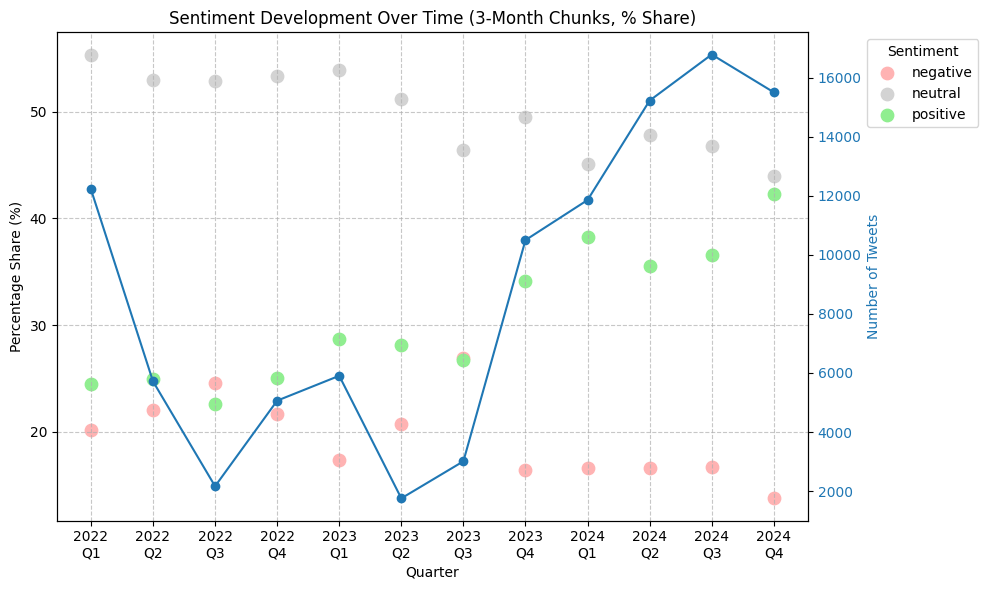

In [25]:
# Create x-tick labels with line breaks: "2022\nQ1", "2022\nQ2", ...
xtick_labels = [f"{q[:4]}\n{q[-2:]}" for q in sentiment_shares.index.astype(str)]

# Get total tweet counts per quarter
tweet_counts = sentiment_counts.sum(axis=1)

fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot sentiment shares as scatter (left y-axis)
for sentiment in sentiment_order:
    ax1.scatter(
        xtick_labels,
        sentiment_shares[sentiment],
        label=sentiment,
        color=sentiment_colors[sentiment],
        s=80
    )
ax1.set_xlabel('Quarter')
ax1.set_ylabel('Percentage Share (%)')
ax1.set_title('Sentiment Development Over Time (3-Month Chunks, % Share)')
ax1.legend(title='Sentiment', loc='upper left', bbox_to_anchor=(1.07, 1))  # prevent overlap with y-ticks
ax1.grid(True, linestyle='--', alpha=0.7)

# Plot tweet counts on secondary y-axis (right)
ax2 = ax1.twinx()
ax2.plot(xtick_labels, tweet_counts, color='tab:blue', marker='o', linestyle='-', label='Tweet Count')
ax2.set_ylabel('Number of Tweets', color='tab:blue')
ax2.tick_params(axis='y', labelcolor='tab:blue')

plt.tight_layout()
plt.show()


# Fine-Tuning

In [26]:
# df_train = pd.read_csv('/Users/enrique/code/EFRdev/08-Final-Project/SolarSoundBytes/raw_data/ForTraining_news_sentiment_analysis.csv')
# df_train.head(2)

In [27]:
# label_list = ['negative', 'neutral', 'positive']
# label_to_id = {l: i for i, l in enumerate(label_list)}
# df_train['label_id'] = df_train['Sentiment'].map(label_to_id)

# #Turning Dataset into HuggingFace object
# dataset = Dataset.from_pandas(df_train)


In [28]:
# print(tokenized_dataset.column_names)

In [29]:
# # Use a pipeline as a high-level helper
# from transformers import pipeline

# model_name = "distilbert/distilbert-base-uncased"
# tokenizer = AutoTokenizer.from_pretrained(model_name)
# model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(label_list))

# #Tokenizing
# def tokenize_function(text):
#     return tokenizer(text["Description"], truncation=True, padding='max_length', max_length=128)

# tokenized_dataset = dataset.map(tokenize_function, batched=True)

# #Split dataset train and val
# split = tokenized_dataset.train_test_split(test_size=0.2, seed=42)
# train_dataset = split['train']
# val_dataset = split['test']

# #Evaluation Metrics
# def compute_metrics(pred):
#     labels = pred.label_ids
#     preds = np.argmax(pred.predictions, axis=1)
#     precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
#     acc = accuracy_score(labels, preds)
#     return {'accuracy': acc, 'f1': f1, 'precision': precision, 'recall': recall}

# #Training set up & Training
# training_args = TrainingArguments(
#     output_dir="./results",
#     learning_rate=2e-5,
#     per_device_train_batch_size=8,
#     per_device_eval_batch_size=8,
#     num_train_epochs=3,
#     weight_decay=0.01,
#     logging_dir="./logs",
#     logging_steps=10,
#     save_total_limit=1,
# )

# trainer = Trainer(
#     model=model, args = training_args, train_dataset=train_dataset, eval_dataset = val_dataset, compute_metrics=compute_metrics)
# trainer.train()


In [30]:
# import transformers
# print(transformers.__file__)
# print(transformers.__version__)

In [31]:
# import accelerate
# print(accelerate.__version__)

In [32]:
# import sys
# print(sys.executable)

In [33]:
# trainer.save_model("./model_finetuned")
# tokenizer.save_pretrained("./model_finetuned")